In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

2025-06-22 16:41:26.043595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750610486.497768      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750610486.615210      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')


In [3]:
credits.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [4]:
keywords.columns

Index(['id', 'keywords'], dtype='object')

In [5]:
movies.columns

Index(['adult', 'budget', 'genres', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count'],
      dtype='object')

In [6]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [7]:
movies.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0


In [8]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [9]:
keywords['keywords'][0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [10]:
# merge movies with keywords dataset on movie id
df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

We want data regarding the crews,cast,keywords,descriptions etc in comma seperated format so we apply appropriate transformation to get that.

In [11]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1: # len(text) only 1 dictionary is in the list
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [12]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [13]:
df.columns


Index(['adult', 'budget', 'genres', 'id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count', 'keywords',
       'crew', 'characters', 'actors'],
      dtype='object')

In [14]:
df['keywords']

0        jealousy, toy, boy, friendship, friends, rival...
1        board game, disappearance, based on children's...
2        fishing, best friend, duringcreditsstinger, ol...
3        based on novel, interracial relationship, sing...
4        baby, midlife crisis, confidence, aging, daugh...
                               ...                        
42368    witch, mythology, legend, serial killer, mocku...
42369                                                     
42370                                  artist, play, pinoy
42371                                                     
42372                                                     
Name: keywords, Length: 42373, dtype: object

In [15]:
# Drop unwanted columns
columns_to_drop = [
    'vote_count',
    'budget',
    'release_date',
    'revenue',
    'runtime',
    'tagline'
]

df = df.drop(columns=columns_to_drop)
df.drop('adult',axis=1,inplace=True)

In [16]:
df.columns

Index(['genres', 'id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'spoken_languages', 'vote_average', 'keywords', 'crew', 'characters',
       'actors'],
      dtype='object')

In [17]:
df.head()

,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,spoken_languages,vote_average,keywords,crew,characters,actors
0,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,English,7.7,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,"English, Français",6.9,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,English,6.5,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,English,6.1,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,English,5.7,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [18]:
df.isna().sum()

genres                  0
id                      0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
spoken_languages        0
vote_average            0
keywords                0
crew                    0
characters              0
actors                  0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genres                42373 non-null  object 
 1   id                    42373 non-null  int64  
 2   original_language     42373 non-null  object 
 3   original_title        42373 non-null  object 
 4   overview              42373 non-null  object 
 5   popularity            42373 non-null  object 
 6   production_companies  42373 non-null  object 
 7   production_countries  42373 non-null  object 
 8   spoken_languages      42373 non-null  object 
 9   vote_average          42373 non-null  float64
 10  keywords              42373 non-null  object 
 11  crew                  42373 non-null  object 
 12  characters            42373 non-null  object 
 13  actors                42373 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 4.5+ MB


Since the user will provide genres names and movies names,we can define the model like this that is 

Since our dataset contains textual information,genres and numeric information we can create a 3 dataset set that 
genres df,text data df and numeric data df and concatenate them to create the final df.
Now Since user will input genre and movies name hence genre df and  text data df which will have movie name and other textual information

Now what we do is a train a auto encoder model on these dataset...

Now then we create movie embeddings from the model.. and also user embedding by taking user movie names,genres and taking those movies rows out of the orignal dataframe and then predicting on those records using model i.e get user embedding and then compare between those 2 embedding by cosine similarity...
then get those reccomendation out

Understanding tfid vectorizer
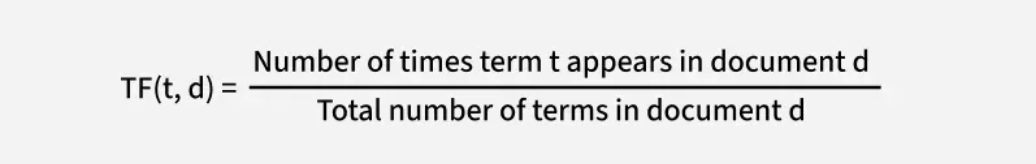
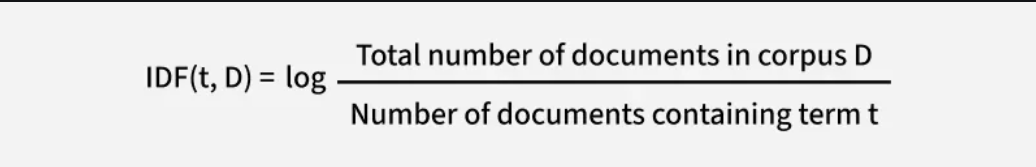

In [20]:
documents = ["hello this guy speaking","living in a world of adventure full of fantasies 2 guys set out to find their love ones",
            "this cat can swim in a body of mercury",
            "This superman works like spiderman"]
v = TfidfVectorizer()
z = v.fit_transform(documents)

In [21]:
print('idf values')
for f,o in zip(v.get_feature_names_out(),v.idf_):
    print(f,":",o)

idf values
adventure : 1.916290731874155
body : 1.916290731874155
can : 1.916290731874155
cat : 1.916290731874155
fantasies : 1.916290731874155
find : 1.916290731874155
full : 1.916290731874155
guy : 1.916290731874155
guys : 1.916290731874155
hello : 1.916290731874155
in : 1.5108256237659907
like : 1.916290731874155
living : 1.916290731874155
love : 1.916290731874155
mercury : 1.916290731874155
of : 1.5108256237659907
ones : 1.916290731874155
out : 1.916290731874155
set : 1.916290731874155
speaking : 1.916290731874155
spiderman : 1.916290731874155
superman : 1.916290731874155
swim : 1.916290731874155
their : 1.916290731874155
this : 1.2231435513142097
to : 1.916290731874155
works : 1.916290731874155
world : 1.916290731874155


In [22]:
# get indexing
print('\nWord indexes:')
print(v.vocabulary_)

# display tf-idf values
print('\ntf-idf value:')
print(z)



Word indexes:
{'hello': 9, 'this': 24, 'guy': 7, 'speaking': 19, 'living': 12, 'in': 10, 'world': 27, 'of': 15, 'adventure': 0, 'full': 6, 'fantasies': 4, 'guys': 8, 'set': 18, 'out': 17, 'to': 25, 'find': 5, 'their': 23, 'love': 13, 'ones': 16, 'cat': 3, 'can': 2, 'swim': 22, 'body': 1, 'mercury': 14, 'superman': 21, 'works': 26, 'like': 11, 'spiderman': 20}

tf-idf value:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 32 stored elements and shape (4, 28)>
  Coords	Values
  (0, 19)	0.5417361046803605
  (0, 7)	0.5417361046803605
  (0, 24)	0.3457831381910465
  (0, 9)	0.5417361046803605
  (1, 16)	0.24916078099586603
  (1, 13)	0.24916078099586603
  (1, 23)	0.24916078099586603
  (1, 5)	0.24916078099586603
  (1, 25)	0.24916078099586603
  (1, 17)	0.24916078099586603
  (1, 18)	0.24916078099586603
  (1, 8)	0.24916078099586603
  (1, 4)	0.24916078099586603
  (1, 6)	0.24916078099586603
  (1, 0)	0.24916078099586603
  (1, 15)	0.39288244325842914
  (1, 27)	0.24916078099586603
  (1, 1

In [23]:
# Parse genres (string to list)
df['genres'] = df['genres'].apply(lambda x: [g.strip().lower() for g in x.split(',')] if pd.notna(x) else [])


In [24]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# --- Load Data ---


# --- Preprocessing ---

# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(df['genres']) # one hot encode feature 
genre_df = pd.DataFrame(genre_features, columns=mlb.classes_)
# TF-IDF for overview + keywords
text_data = (
    df['overview'].fillna('') + ' ' +
    df['original_title'].fillna('') + ' ' + # I added this portion
    df['keywords'].fillna('') + ' ' +
    df['production_companies'].fillna('') + ' ' +
    df['production_countries'].fillna('') + ' ' +
    df['spoken_languages'].fillna('') + ' ' +
    df['crew'].fillna('') + ' ' +
    df['characters'].fillna('') + ' ' +
    df['actors'].fillna('')
)
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(text_data).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names_out())

# Normalize popularity & vote_average
scaler = MinMaxScaler()
numeric_df = df[['popularity', 'vote_average']].copy()
numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)

# --- Final Feature Set ---
features = pd.concat([genre_df, tfidf_df, numeric_df], axis=1)




In [25]:
tfidf_df

,aaron,about,adam,after,against,agent,al,alan,albert,alex,...,woman,women,work,world,year,years,york,you,young,日本語
0,0.000000,0.000000,0.000000,0.000000,0.057521,0.0,0.0,0.050711,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.090531,0.000000,0.000000,0.0,0.0,0.521492,0.000000,0.0,...,0.000000,0.000000,0.000000,0.075251,0.000000,0.084888,0.0,0.0,0.122088,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.160048,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.110638,0.000000,0.000000,0.0,0.0,0.212439,0.123597,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42368,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
42369,0.146001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.286868,0.000000,0.103489,0.122594,0.116742,0.0,0.0,0.000000,0.0
42370,0.000000,0.251901,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.421605,0.000000,0.334661,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
42371,0.000000,0.104106,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [26]:
text_data

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
42368    A film archivist revisits the story of Rustin ...
42369    It's the year 3000 AD. The world's most danger...
42370    An artist struggles to finish his work while a...
42371    In a small town live two brothers, one a minis...
42372    50 years after decriminalisation of homosexual...
Length: 42373, dtype: object

In [27]:
df['genres']

0         [animation, comedy, family]
1        [adventure, fantasy, family]
2                   [romance, comedy]
3            [comedy, drama, romance]
4                            [comedy]
                     ...             
42368                        [horror]
42369               [science fiction]
42370                         [drama]
42371                              []
42372                              []
Name: genres, Length: 42373, dtype: object

In [28]:
features

,,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,...,work,world,year,years,york,you,young,日本語,popularity,vote_average
0,0,0,0,1,1,0,0,0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.040087,0.77
1,0,0,1,0,0,0,0,0,1,1,...,0.000000,0.075251,0.000000,0.084888,0.0,0.0,0.122088,0.0,0.031079,0.69
2,0,0,0,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.021394,0.65
3,0,0,0,0,1,0,0,1,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.007049,0.61
4,0,0,0,0,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.015320,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42368,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000706,0.70
42369,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.103489,0.122594,0.116742,0.0,0.0,0.000000,0.0,0.001208,0.35
42370,0,0,0,0,0,0,0,1,0,0,...,0.334661,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000326,0.90
42371,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000006,0.00


In [29]:
df_c = df.copy()

In [30]:

# --- Build Model ---
input_dim = features.shape[1]
input_layer = Input(shape=(input_dim,), name='movie_input')
x = Dense(256, activation='relu')(input_layer)
x = Dense(128, activation='relu')(x)
embedding = Dense(64, activation='linear', name='embedding')(x)
# Decoder
x = Dense(128, activation='relu')(embedding)
x = Dense(256, activation='relu')(x)

output_layer = Dense(input_dim, activation='linear')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# --- Train to reconstruct (autoencoder-style pretraining) ---
X_train, X_test = train_test_split(features.values, test_size=0.2, random_state=42)
model.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_test, X_test))

# --- Get Embeddings ---
movie_embeddings = model.predict(features.values)

# --- Recommend Similar Movies ---
""""
from sklearn.metrics.pairwise import cosine_similarity

user_embedding = model.predict(user_profile)
sim_scores = cosine_similarity(user_embedding, movie_embeddings).flatten()

# Top N recommendations
df_c['score'] = sim_scores
recommendations = df_c.sort_values(by='score', ascending=False)

# Show top 10
print(recommendations[['original_title', 'score']].head(10))
"""

I0000 00:00:1750610568.956454      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750610568.957199      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1750610574.011260      60 service.cc:148] XLA service 0x7b1de800c860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750610574.012773      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750610574.012794      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750610574.398629      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 73/530 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053

I0000 00:00:1750610575.666502      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 12/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

'"\nfrom sklearn.metrics.pairwise import cosine_similarity\n\nuser_embedding = model.predict(user_profile)\nsim_scores = cosine_similarity(user_embedding, movie_embeddings).flatten()\n\n# Top N recommendations\ndf_c[\'score\'] = sim_scores\nrecommendations = df_c.sort_values(by=\'score\', ascending=False)\n\n# Show top 10\nprint(recommendations[[\'original_title\', \'score\']].head(10))\n'

In [31]:
features.head()

,,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,...,work,world,year,years,york,you,young,日本語,popularity,vote_average
0,0,0,0,1,1,0,0,0,1,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040087,0.77
1,0,0,1,0,0,0,0,0,1,1,...,0.0,0.075251,0.0,0.084888,0.0,0.0,0.122088,0.0,0.031079,0.69
2,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.021394,0.65
3,0,0,0,0,1,0,0,1,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.007049,0.61
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.015320,0.57


In [32]:
# --- Get Embeddings ---
movie_embeddings = model.predict(features.values)


1325/1325 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [33]:
# --- Simulated User Profile ---
liked_titles = ["American Psycho"]
liked_movies = features[df['original_title'].isin(liked_titles)]
user_profile = liked_movies.mean().values.reshape(1, -1)

In [34]:
# --- Recommend Similar Movies ---
from sklearn.metrics.pairwise import cosine_similarity

user_embedding = model.predict(user_profile)
sim_scores = cosine_similarity(user_embedding, movie_embeddings).flatten()

# Create a new DataFrame for recommendations
recommendations_df = df.copy()
recommendations_df['score'] = sim_scores

# Sort by score and show top 10
top_recommendations = recommendations_df.sort_values(by='score', ascending=False)
print(top_recommendations[['original_title', 'score']].head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
            original_title     score
3360       American Psycho  1.000000
1761      A Perfect Murder  0.980991
37442       The Accountant  0.979300
13832  Law Abiding Citizen  0.979184
39125         Patriots Day  0.978479
23295         Nightcrawler  0.978456
3128           Boiler Room  0.975429
1572         The Rainmaker  0.973368
7903            Collateral  0.973338
42111          Shot Caller  0.972846


In [35]:
liked_titles = ["American Psycho"]
liked_genres = ['drama','family']  # user-input favorite genres


In [36]:
# Find vectors for liked movies
liked_movie_vectors = features[df_c['original_title'].isin(liked_titles)]


In [37]:
# 'genre_encoded' contains one-hot genre columns like ['Drama', 'Crime', 'Action', ...]
genre_columns = genre_df.columns.tolist()


In [38]:
genre_columns

['',
 'action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'foreign',
 'history',
 'horror',
 'music',
 'mystery',
 'romance',
 'science fiction',
 'thriller',
 'tv movie',
 'war',
 'western']

In [39]:
# Create a zero vector for all genres
genre_vector = pd.Series([0] * len(genre_columns), index=genre_columns, dtype=float)

# Set the liked genres to 1
for g in liked_genres:
    if g in genre_vector:
        genre_vector[g] = 1.0

# Broadcast genre_vector to the same shape as features
genre_vector_full = pd.Series([0.0] * features.shape[1], index=features.columns)

# Insert the genre values into their positions
genre_vector_full.update(genre_vector)


In [40]:
# Average movie vector
liked_movie_mean = liked_movie_vectors.mean()

# Combine with genre vector (weighted sum)
user_profile_series = 0.6 * liked_movie_mean + 0.4 * genre_vector_full
user_profile = user_profile_series.values.reshape(1, -1)


In [41]:
# Get movie embeddings
movie_embeddings = model.predict(features.values)
user_embedding = model.predict(user_profile)

# Compute similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_scores = cosine_similarity(user_embedding, movie_embeddings).flatten()

# Attach and sort
df_c['score'] = sim_scores
recommendations = df_c.sort_values(by='score', ascending=False)

# Top 10
print(recommendations[['original_title', 'score']].head(10))


1325/1325 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
                    original_title     score
3360               American Psycho  0.937516
1761              A Perfect Murder  0.925338
13832          Law Abiding Citizen  0.924101
19382                   The Iceman  0.923981
30145                 Sand Castles  0.923630
24224          A Most Violent Year  0.923414
1393              City of Industry  0.922763
10105        A History of Violence  0.922547
1572                 The Rainmaker  0.922225
7754   María, llena eres de gracia  0.921813


### Reccomendation in function

In [42]:
features[df_c['original_title'].isin(["The Godfather", "The Wolf of Wall Street","Guardians Of The Galaxy","Men in Black"])]

,,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,...,work,world,year,years,york,you,young,日本語,popularity,vote_average
821,0,0,0,0,0,1,0,1,0,0,...,0.0,0.000000,0.0,0.035322,0.00000,0.0,0.000000,0.0,0.075087,0.85
1486,0,1,1,0,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.028824,0.69
21166,0,0,0,0,1,1,0,1,0,0,...,0.0,0.015807,0.0,0.017831,0.02065,0.0,0.025645,0.0,0.029923,0.79


In [43]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(liked_titles, liked_genres, features, df_c, model, genre_columns, top_n=10,
                        movie_weight=0.7, genre_weight=0.3):
    """
    Generate movie recommendations based on liked movie titles and genres.

    Parameters:
    - liked_titles (list): List of movie titles the user likes.
    - liked_genres (list): List of genres the user likes (strings).
    - features (DataFrame): Full feature matrix used for model input.
    - df_c (DataFrame): Original movie metadata (should include 'original_title').
    - model (keras Model): Trained autoencoder model.
    - genre_columns (list): List of genre one-hot column names.
    - top_n (int): Number of top recommendations to return.
    - movie_weight (float): Weight for movie-based user profile.
    - genre_weight (float): Weight for genre-based user profile.

    Returns:
    - DataFrame of top recommended movies with similarity scores.
    """
    # 1. Get liked movie vectors
    liked_movie_vectors = features[df_c['original_title'].isin(liked_titles)]

    if liked_movie_vectors.empty:
        raise ValueError("None of the liked titles found in the dataset.")

    # 2. Create average movie profile
    liked_movie_mean = liked_movie_vectors.mean()

    # 3. Create genre preference vector
    genre_vector = pd.Series([0.0] * len(genre_columns), index=genre_columns)
    for g in liked_genres:
        if g in genre_vector:
            genre_vector[g] = 1.0

    # 4. Broadcast genre_vector to full feature size
    genre_vector_full = pd.Series([0.0] * features.shape[1], index=features.columns)
    genre_vector_full.update(genre_vector)

    # 5. Combine movie and genre profiles
    user_profile_series = movie_weight * liked_movie_mean + genre_weight * genre_vector_full
    user_profile = user_profile_series.values.reshape(1, -1)

    # 6. Get embeddings
    movie_embeddings = model.predict(features.values)
    user_embedding = model.predict(user_profile)

    # 7. Compute cosine similarities
    sim_scores = cosine_similarity(user_embedding, movie_embeddings).flatten()

    # 8. Attach scores and sort
    df_c['score'] = sim_scores
    recommendations = df_c.sort_values(by='score', ascending=False)

    return recommendations[['original_title', 'score']].head(top_n)


In [44]:
liked_titles = ["The Godfather", "The Wolf of Wall Street","Guardians Of The Galaxy","Men in Black"]
liked_genres = ["Crime", "Drama","Horror","Adventure"]

recs = get_recommendations(
    liked_titles=liked_titles,
    liked_genres=liked_genres,
    features=features,
    df_c=df_c,
    model=model,
    genre_columns=genre_df.columns.tolist(),  # Your one-hot genre cols
    top_n=10
)

print(recs)


1325/1325 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
                original_title     score
21166  The Wolf of Wall Street  0.937495
1172                 The Sting  0.923637
3455          Monsieur Verdoux  0.915458
36997                 War Dogs  0.912941
25328           Jimmy the Gent  0.904422
5671               Adaptation.  0.900159
13424             Blonde Crazy  0.897435
10925      Ensayo de un crimen  0.892316
11999                In Bruges  0.881928
6685    Les Invasions barbares  0.871835


In [45]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.3 MB/s eta 0:00:00


In [46]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model

# Load preprocessed data
# Assuming these were saved after training
#features = pd.read_pickle("features.pkl")     # Your features with genres
#df_c = pd.read_pickle("df_c.pkl")             # Original metadata with titles, etc.
#genre_columns = pd.read_pickle("genre_columns.pkl")  # List of one-hot genre columns
#model = load_model("autoencoder_model.h5")    # Trained autoencoder model

# Precompute embeddings for all movies
movie_embeddings = model.predict(features.values)

# --- Recommender Function ---
def get_recommendations(liked_titles, liked_genres, top_n=10, movie_weight=0.7, genre_weight=0.3):
    liked_movie_vectors = features[df_c['original_title'].isin(liked_titles)]
    if liked_movie_vectors.empty:
        return pd.DataFrame(columns=['original_title', 'score'])

    liked_movie_mean = liked_movie_vectors.mean()

    # Genre vector
    genre_vector = pd.Series([0.0] * len(genre_columns), index=genre_columns)
    for g in liked_genres:
        if g in genre_vector:
            genre_vector[g] = 1.0

    genre_vector_full = pd.Series([0.0] * features.shape[1], index=features.columns)
    genre_vector_full.update(genre_vector)

    user_profile_series = movie_weight * liked_movie_mean + genre_weight * genre_vector_full
    user_profile = user_profile_series.values.reshape(1, -1)

    user_embedding = model.predict(user_profile)
    sim_scores = cosine_similarity(user_embedding, movie_embeddings).flatten()

    df_c['score'] = sim_scores
    recommendations = df_c.sort_values(by='score', ascending=False)
    return recommendations[['original_title', 'score']].head(top_n)

# --- Streamlit UI ---
st.set_page_config(page_title="🎬 Movie Recommender", layout="centered")
st.title("🎬 Personalized Movie Recommender")

all_titles = sorted(df_c['original_title'].dropna().unique())
liked_titles = st.multiselect("Select movies you loved watching:", all_titles)

available_genres = sorted(genre_columns)
liked_genres = st.multiselect("Select your favorite genres:", available_genres)

if st.button("🎯 Recommend"):
    if not liked_titles and not liked_genres:
        st.warning("Please select at least one movie or genre.")
    else:
        with st.spinner("Finding the best matches for you..."):
            recs = get_recommendations(liked_titles, liked_genres, top_n=10)
        st.success("Here are your recommendations:")
        st.table(recs)

1325/1325 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


2025-06-22 16:43:51.583 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 16:43:51.584 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 16:43:51.981 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-22 16:43:51.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 16:43:51.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 16:43:52.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 16:43:52.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [47]:
# Save features DataFrame
features.to_pickle("features.pkl")



# Save genre column names
import pickle
with open("genre_columns.pkl", "wb") as f:
    pickle.dump(genre_columns, f)

# Save the trained model
model.save("autoencoder_model.h5")


In [48]:
import sys
print(sys.version)


3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [49]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [50]:
import zipfile

with zipfile.ZipFile("data_file.zip", "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("df_c.pkl")

  

FileNotFoundError: [Errno 2] No such file or directory: 'df_c.pkl'

In [ ]:
# In training script:
model.save("autoencoder_model.keras")  # new recommended format


In [ ]:
# Path to your .pkl file
pkl_file = "features.pkl"
zip_file = "features.zip"

# Create a zip archive containing the pkl file
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(pkl_file)

In [ ]:
# Save embeddings to a .pkl file
with open("movie_embeddings.pkl", "wb") as f:
    pickle.dump(movie_embeddings, f)